 # 1. Imagenet Pretrained
 

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [ ]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
from urllib.request import urlretrieve
import json

imagenet_json, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
  imagenet_labels = json.load(f)

In [ ]:
imagenet_labels

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),

])

In [ ]:
class Normalize(nn.Module):
  def __init__(self, mean, std) :
    super(Normalize, self).__init__()
    self.register_buffer('mean', torch.Tensor(mean))
    self.register_buffer('std', torch.Tensor(std))

  def forward(self, x):
    mean = self.mean.reshape(1, 3, 1, 1)
    std = self.std.reshape(1, 3, 1, 1)
    return (input - mean) / std

rester_buffer로 layer을 등록하면
- optimzer가 업데이트 하지 않음
- 값은 존재(하나의 layer로써 작용)
- state_dict()로 확인 가능
- gpu 연산 가능

즉, 모델 매개 변수로 간주되지 않는 버퍼를 등록하는데 사용됨

In [ ]:
# pytorch에서 제공하는 파라미터 사용
model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torch.hub.load("pytorch/vision:v0.6.0", "resnet18", pretrained=True)
).to(device).eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# 2. ResNet18, CIFAR10

### 모델 정의 및 인스턴스 초기화

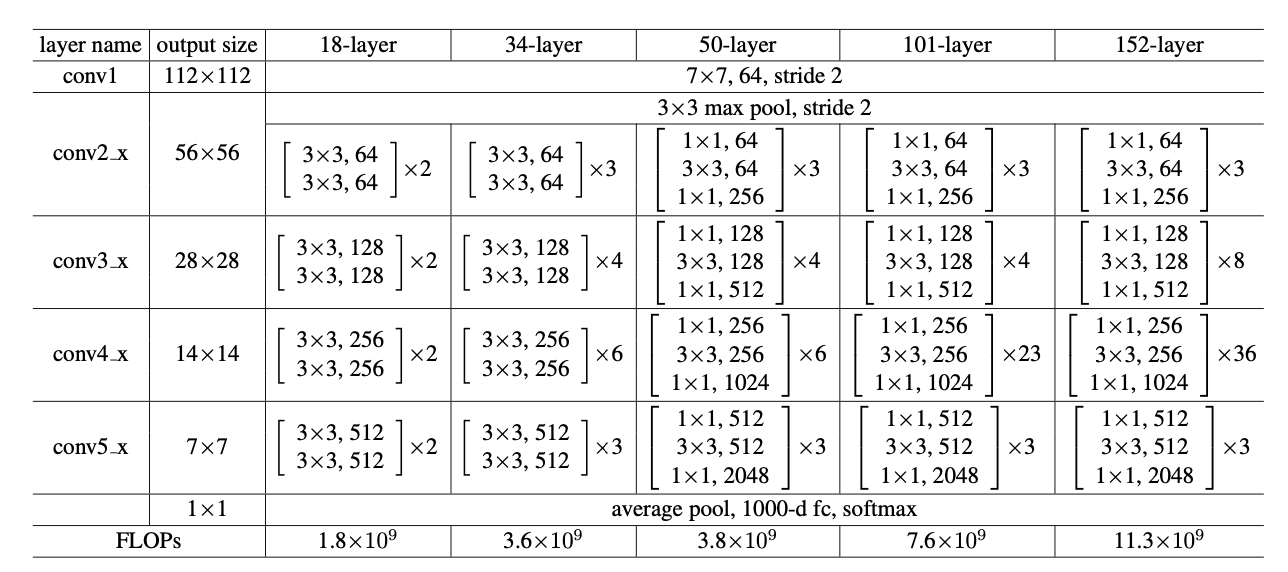


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os


class BasicBlock(nn.Module):
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(planes)
      )
    
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64 # 처음 필터 개수

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)

    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512, num_classes)


  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1) # 각 블락에서 첫 번째 stride이외에는 stride를 1로 맞춤. 
    # 1이 아닌 경우는 input/output의 dimension이 달라 맞춰줘야 하는 경우
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes
    return nn.Sequential(*layers)

  
  def forward(self, x):
    out = F.relu(self.bn1((self.conv1(x))))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out



def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])




### 데이터셋 다운로드


In [6]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, 
                                             transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                           transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                               shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, 
                                          shuffle=False, num_workers=4)



Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 환경 설정 및 학습 함수 정의

In [28]:
device = 'cuda'

net = ResNet18()
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True # cudnn의 자동 튜너 활성화, 하드웨어에 맞게 최상의 알고리즘을 찾는다. 입력크기 고정, 모델이 static하게 작동한다면 유효

learning_rate = 0.1
file_name = 'resnet18_cirfar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)


def train(epoch):
  print(f'\n[Train epoch: {epoch} ]')
  net.train()
  train_loss = 0
  correct = 0 # 맞는 개수
  total = 0

  for batch_idx, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.to(device), targets.to(device) # gpu 할당
    optimizer.zero_grad() # grad 초기화

    benign_outputs = net(inputs)
    loss = criterion(benign_outputs, targets)
    loss.backward() # autograd

    optimizer.step() # weight update
    train_loss += loss.item()
    _, predicted = benign_outputs.max(1)

    total += targets.size(0)
    correct += predicted.eq(targets).sum().item() # target값과 비교해서 예측값이 동일한 경우의 개수 합

    if batch_idx % 100 == 0:
      print(f'\n Current batch : {str(batch_idx)}')
      print(f'Current benign train accuracy : {str(predicted.eq(targets).sum().item() / targets.size(0))}')
      print(f'Current benign train loss : {loss.item()}')

  print(f'\nTotal benign train accuracy : {100. * correct/total}')
  print(f'Total benign train loss : {train_loss}')



def test(epoch):
  print(f'\n [Test epoch : {epoch} ]')
  net.eval() # evaluation
  loss = 0
  correct = 0 # 맞는 개수
  total = 0

  for batch_idx, (inputs, targets) in enumerate(test_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    total += targets.size(0)

    outputs = net(inputs)
    loss += criterion(outputs, targets).item()

    _, predicted = outputs.max(1)
    correct += predicted.eq(targets).sum().item() 

  print(f'\nTest accuracy : {100. * correct / total}')
  print(f'Test average loss : {loss / total}')

  state = {
      'net' : net.state_dict()
  }

  if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
  torch.save(state, './checkpoint/'+file_name)
  print('Model Saved!')


def adjust_learning_rate(optimzer, epoch): # epoch가 진행됨에 따른 learning rate 조정
  lr = learning_rate
  if epoch >= 100:
    lr /= 10 # 기존 learning rate의 1/10
  if epoch >= 150:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr





### 학습 진행

In [ ]:
for epoch in range(0, 200):
  adjust_learning_rate(optimizer, epoch)
  train(epoch)
  test(epoch)


[Train epoch: 0 ]

 Current batch : 0
Current benign train accuracy : 0.1015625
Current benign train loss : 2.4466824531555176

 Current batch : 100
Current benign train accuracy : 0.25
Current benign train loss : 2.0131611824035645

 Current batch : 200
Current benign train accuracy : 0.3828125
Current benign train loss : 1.699218511581421

 Current batch : 300
Current benign train accuracy : 0.296875
Current benign train loss : 1.6032079458236694

Total benign train accuracy : 31.304
Total benign train loss : 752.1228649616241

 [Test epoch : 0 ]

Test accuracy : 37.85
Test average loss : 0.01690951648950577
Model Saved!

[Train epoch: 1 ]

 Current batch : 0
Current benign train accuracy : 0.3828125
Current benign train loss : 1.710746169090271

 Current batch : 100
Current benign train accuracy : 0.4453125
Current benign train loss : 1.5082834959030151

 Current batch : 200
Current benign train accuracy : 0.5390625
Current benign train loss : 1.2965974807739258

 Current batch : 3